# Preprocessing

Here we present the pre-processing done to the dataset. We have basically two relevant task, that will change slightly depending on the ML method ( `feature-based` or `deep-learning` ) we are using. The basic steps are the following:

1) Understand the cleaning of the dataset ( jut conceptually ).
2) **Train/Test split** - here we need to make splits by patients, also being aware of class imbalances.
3) Apply preprocessing based on **training set**, we will create a class to be able to apply different steps and store the new data in memory.

**Note 1:** For number (3) it could make sense to have a `DatasetClass` able to apply _different pipelines_. It could make sense to apply this `on-loading` as it wouldn't be necessary to store and move the files to other environment ( if the models are trained in Colab or other services )

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import cv2
import os

random_state = 2023

BASE_DATA_DIR = os.path.join('data', 'train')
TRAINING_SET_FILE = os.path.join('data', 'training_set.csv')
TESTING_SET_FILE = os.path.join('data', 'testing_set.csv')

## 1. Cleaning Idea

It is relevant to say that the previously defined `perturbation` are, in practice, nothing more than a kind of `data augmentation`. This is a really helpful process for Machine Learning algorithms and, given this, is something we want to use.

We have two ways to do this (**note:** we want to develop a process useful for the three different classification approaches we are using ):

1) We keep the dataset as it is ( with some minor preprocessing on top ) and, if wanted, apply _data augmentation techniques_ on top of it. -> This could be closer to the actual `test dataset`, so it could be benefitial to our performance.

2) We clean the dataset to ideally have only "good images" and apply _data augmentation_ on top of it. This could allow us to perform more "aggresive" augmentation techniques ( as we start from a "un-perturbed" image ). Also, if the cleaning is not "perfect" it wouldn't be a real problem (as it would be a small augmentation) -> We would have to clean each `test` sample too.

**Idea:** We will develop a cleaning idea, but ultimatly we will test both pipelines to check what yields better results.

## 2. Train/Test Split

Ideally we want to define a unique `training` and `testing` datasets to compare in a un-biased way the methods we are developing. 

* As we are working with patients that can have more than one image, we have to split by patient ids.
* As we are working with an imbalanced dataset, we have to split taking into account the stratify of the datasets ( both sets keep the same balance )

In [3]:
labels_file = pd.read_csv( os.path.join(BASE_DATA_DIR, 'labels_train.csv'))
labels_file['patient_id'] = labels_file['file'].str.split('_').str[0]
print("Total number of images:", len(labels_file) )

# drop file column and drop duplicates
patients_file = labels_file.drop(['file'], axis=1)
patients_file = patients_file.drop_duplicates(subset=['patient_id']).reset_index(drop=True)

# show head and stats
patients_file.head()
print("Total number of distinct patients:", len(patients_file) )

Total number of images: 15470
Total number of distinct patients: 12086


Now we do the split based on the `patient_id`, take into account the class distribution:

In [4]:
classes, counts = np.unique(patients_file['label'], return_counts=True)
original_dist = { classes[i]: counts[i] / len(patients_file) for i in range(len(classes)) }
print("Original class distribution:", original_dist )

Original class distribution: {'N': 0.6057421810359093, 'P': 0.27345689227205033, 'T': 0.12080092669204037}


In [5]:
TRAIN_SIZE = 0.80

# make the actual split
training_ids, testing_ids = train_test_split(
    patients_file['patient_id'].values,
    train_size=TRAIN_SIZE,
    stratify=patients_file['label'].values,
    random_state=random_state,
)
training_data = labels_file[ labels_file['patient_id'].isin( training_ids )].reset_index( drop=True )
testing_data = labels_file[ labels_file['patient_id'].isin( testing_ids )].reset_index( drop=True )
print("Training data size:", len(training_data), "samples" )
print("Testing data size:", len(testing_data), "samples" )

Training data size: 12365 samples
Testing data size: 3105 samples


In [6]:
for split in [ training_data, testing_data ]:
    split_classes, split_counts = np.unique( split['label'], return_counts=True)
    split_dist = { split_classes[i]: split_counts[i] / len(split) for i in range(len(split_classes)) }
    print("Original class distribution:", split_dist )

Original class distribution: {'N': 0.6045289122523251, 'P': 0.2750505458956733, 'T': 0.12042054185200161}
Original class distribution: {'N': 0.6051529790660225, 'P': 0.27342995169082124, 'T': 0.1214170692431562}


From the previous cell we can check that the classes follow the same distribution on all the splits. Let's **check that there is no leakeage between both sets** and store the datasets.

In [7]:
# no training file is in testing
assert training_data['file'].isin( testing_data['file']).sum() == 0
assert testing_data['file'].isin( training_data['file']).sum() == 0

# no training patient is in testing
assert training_data['patient_id'].isin( testing_data['patient_id']).sum() == 0
assert testing_data['patient_id'].isin( training_data['patient_id']).sum() == 0

# store the datasets
training_data.to_csv( TRAINING_SET_FILE, index=False )
testing_data.to_csv( TESTING_SET_FILE, index=False )

## 3. Cleaning the dataset

The parameters for this section should be extracted only from the the `training_dataset`, as so, we will only look at this set for now.

The general idea will be to create an _automatic_ way to extract these parameters ( from the training split ) and then, been apply to store the values and apply them to the test split too.

**Note:** We will create a set-up `class` to calculate the parameters for the cleaning, the idea for this class is to be flexible so we can "try" different combinations.

In [8]:
training_data = pd.read_csv( TRAINING_SET_FILE )
training_data.head()

,file,label,patient_id
0,P00001_1.png,N,P00001
1,P00001_2.png,N,P00001
2,P00005_1.png,T,P00005
3,P00005_2.png,T,P00005
4,P00007_1.png,N,P00007


It is relevant to remember our cleaning approach: we will try to make all the images as homogenous as possible, but ultimatly small persistent perturbation should be a problem. The problems were explored in the previous notebook, here we are just trying to optimise the way we look for the `hyperparameters`:

- Noisy Images ( `std_thresh` -> we will study this value here ).
- Blurred Images ( `focus_thresh`, `kernel_size` and `factor` -> this come only from visual inspection ).
- Negative Images ( `mean_threash` -> we will study this value here ).

We will also include some other pre-processing techniques, like getting rid of "black frames" on the images and `histogram equalisation`. In this notebook we will get the relevant values for the pre-processing function.

**Note:** we will finally store the dataset on disk in order to avoid performing these steps every time we are trying to load the data ( specially for the training of DL models ).

In [28]:
from data import remove_img_borders, equalisator

# this function should emulate the standard preprocessing
def read_image( img_name, size=(256, 256) ):
    """ Read the image and apply a standard pre-processing operations """
    img_path = os.path.join( BASE_DATA_DIR, img_name )
    img = cv2.imread( img_path, cv2.IMREAD_GRAYSCALE )
    if ( size is not None ):
        img = cv2.resize( img, size )
        
    # normalisation will cover some boundary errors on the resizing
    img = cv2.normalize(img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    
    # remove borders
    img = remove_img_borders( img, thresh=10)
    if ( size is not None ):
        img = cv2.resize( img, size )
        
    # histogram equalisation tries to smoth the distribution of pixels to enhace the image
    img = equalisator.apply( img )
    return img

Let's understand the `std_thresh` and `mean_thresh` hyper-parameters. We will plot the measurements on a small portion of the dataset.


In [108]:
SAMPLE_SIZE = 500

np.random.seed( seed=random_state )
random_samples = np.random.choice( training_data['file'].values, size=SAMPLE_SIZE, replace=False,  )

img_stats = {}
for i, img_name in tqdm( enumerate( random_samples ), desc='Extracting values', total=SAMPLE_SIZE):
    img = read_image( img_name, size=(256, 256))
    img_center_y, img_center_x = img.shape[0] // 2, img.shape[1] // 2

    crops = []
    
    # take corners
    crop_height, crop_width = 32, 32
    crops.append( img[ :crop_height, :crop_width] ) # corner0_crop
    crops.append( img[ :crop_height, -crop_width:] ) # corner1_crop
    crops.append( img[ -crop_height:, :crop_width] ) # corner2_crop
    crops.append( img[ -crop_height:, -crop_width:] ) # corner3_crop

    # center crop
    crops.append( img[ 
        img_center_y - (crop_height//2):img_center_y + (crop_height//2),
        img_center_x - (crop_width//2):img_center_y + (crop_width//2)
    ] )

    # take mid bottom crop
    crop_height, crop_width = 64, 128
    crops.append( img[
        -crop_height:,
        img_center_x - (crop_width // 2):img_center_y + (crop_width // 2)
    ] )

    img_stats[img_name] = np.array([ [crop.mean(), crop.std() ] for crop in crops ])

print(f"Took values for {len(img_stats)} images!")

Extracting values: 100%|██████████████████████████████████████████████| 500/500 [00:04<00:00, 116.45it/s]

Took values for 500 images!


Now we can visualise the distribution:

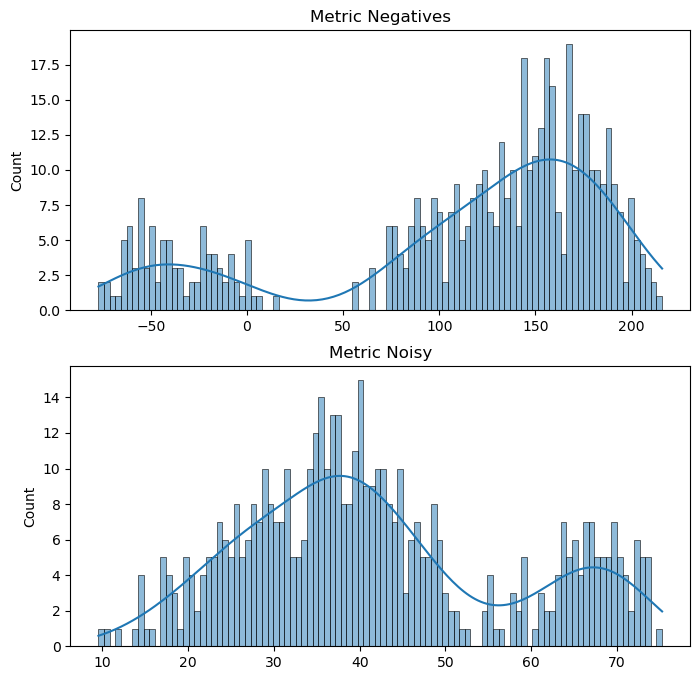

In [246]:
mean_stat = lambda sample: ( sample[4:].mean(axis=0) - 0.5 * sample[:4].mean(axis=0) )[0]
std_stat = lambda sample: sample[[0, 1, 4, 5], 1].mean()

stats_for_mean = np.array( [ mean_stat(img_stats[name]) for name in img_stats ] )
stats_for_std = np.array( [ std_stat(img_stats[name]) for name in img_stats ] )

# select a stat to visualise
crop_stats = stats_for_std

fig, ax = plt.subplots( 2, 1, figsize=(8, 8))

# plot mean
sns.histplot( stats_for_mean, ax=ax[0], kde=True, bins=100 )
ax[0].set_title('Metric Negatives')

sns.histplot( stats_for_std, ax=ax[1], kde=True, bins=100 )
ax[1].set_title('Metric Noisy')
plt.show()

We can see there is some natural threshold formed. It makes sense to also have a smaller mode in the bi-model, as negative/noisy images should be found way less than "normal" images.

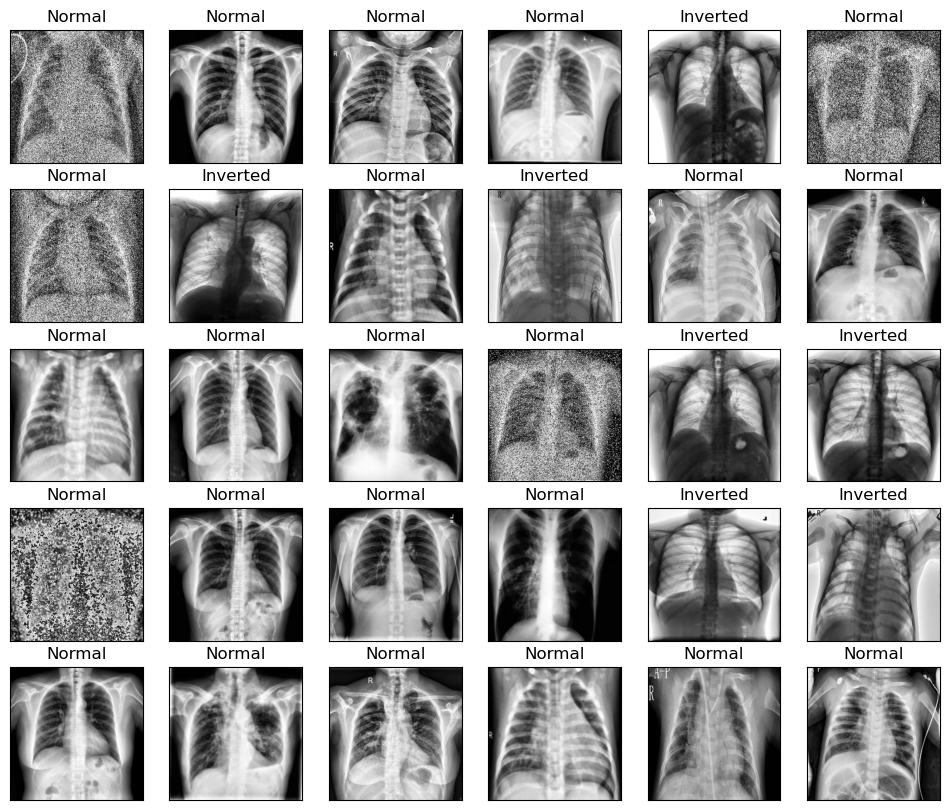

In [247]:
SAMPLE_SIZE = 30
INVERT_THRESHOLD = 65 # conservative value

# test mean threshold
activated_samples = [ n for n in img_stats if ( mean_stat(img_stats[n]) < INVERT_THRESHOLD )]
non_activated_samples = [ n for n in img_stats if ( mean_stat(img_stats[n]) >= INVERT_THRESHOLD )]

# to show samples
show_samples = np.random.choice( 
    [ n for n in img_stats.keys() if n not in non_activated_samples[::2] ],
    size=SAMPLE_SIZE,
    replace=False
)
np.random.shuffle( show_samples )

fig, ax = plt.subplots(5, 6, figsize=(12, 10))
for num in range( SAMPLE_SIZE ):
    i, j = num // 6, num % 6
    img = read_image( show_samples[num] )
    ax[i, j].imshow(img, cmap='gray'), ax[i, j].set_xticks([]), ax[i, j].set_yticks([])
    ax[i, j].set_title( "Inverted" if show_samples[num] in activated_samples else "Normal")
plt.show()

We can see that more detecting inverting images, our **metric works really good**, with the only exeptions being when we have `noise` in the image. Then, we have to detect noise before detecting negative in our pipeline.

> The created metric measures the mean pixel value at the center of the image and add a negative factor for the mean on the corners ( for a normal image they should be darker ).

Let's check the same problem for the _noisy detection_.

**Note:** here we can actually set a lower threshold as the real the operations performed do not really lower the quality of the image a lot.

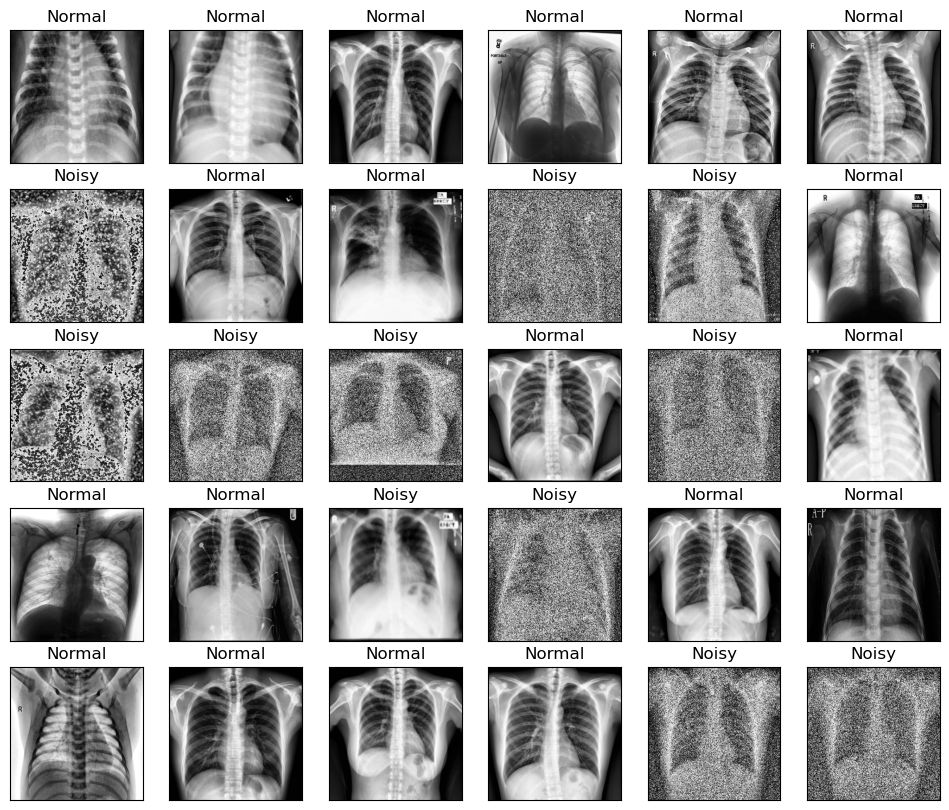

In [250]:
SAMPLE_SIZE = 30
NOISE_THRESHOLD = 53

# test mean threshold
activated_samples = [ n for n in img_stats if ( std_stat(img_stats[n]) >= NOISE_THRESHOLD )]
non_activated_samples = [ n for n in img_stats if ( std_stat(img_stats[n]) < NOISE_THRESHOLD )]

# to show samples
show_samples = np.random.choice( 
    [ n for n in img_stats.keys() if n not in non_activated_samples[::2] ],
    size=SAMPLE_SIZE,
    replace=False
)
np.random.shuffle( show_samples )

fig, ax = plt.subplots(5, 6, figsize=(12, 10))
for num in range( SAMPLE_SIZE ):
    i, j = num // 6, num % 6
    img = read_image( show_samples[num] )
    ax[i, j].imshow(img, cmap='gray'), ax[i, j].set_xticks([]), ax[i, j].set_yticks([])
    ax[i, j].set_title( "Noisy" if show_samples[num] in activated_samples else "Normal")
plt.show()

We can check that there are, in fact, some `false positives`. Nevertheless,  it is not really problematic for us, as the solution to noise reduction does not perturbe strongly the image.

## 3.5 Pre-processing Pipeline:

The full preprocessing pipeline is coded in the `data.py` file. Here we provide some examples of how this class works and can be used.

training_set, testing_set
ProcessTrainingSet( image_size, {steps to apply} ) -> Store in memory
for train, valid in cross_validation(training_set) ---
    create trainDataset
    trainDataset.setup()
        - normalise image values(?)
    trainModel
    